## The Variational Quantum Thermalizer

Author: Jack Ceroni 

In [1]:
# Starts by importing all of the necessary dependencies

import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import random
import math
from tqdm import tqdm
import networkx as nx
import seaborn

### Introduction

In this Notebook, we will be discussing how to go about implementing and experimenting a recently proposed quantum algorithm called the **Variational Quantum Thermalizer**. Essentially, this algorithm is able to use a variational approach to reconstruct the thermal state of a given Hamiltonian at a given temperature. This is a task that is performed much more efficiently on a quantum device than a classical simulations performing the same calculations (for large enough systems). In fact, the original paper demonstrates that the VQT is actually a generalization of VQE, and as the effective "temperature" of our simulation approaches zero, our algorithm similarly approaches the VQE.

### The Idea

Before we actually jump into simulations of this algorithm, we will attempt to understand the mathematical and physical theory that makes this theory possible. For more background on variational quantum algorithms, and why VQE actually works, check out the other tutorials in the QML gallery (like [this one](https://pennylane.ai/qml/demos/tutorial_vqe.html)).

First off all, let us consider what we are actually trying to accomplish using this algorithm. We want to construct a **thermal state**, which is defined as:

<br>
$$\rho_\text{thermal} \ = \ \frac{e^{- H \beta / k_B}}{\text{Tr}(e^{- H \beta / k_B})} \ = \ \frac{e^{- H \beta / k_B}}{Z_{\beta}}$$
<br>

Where $H$ is the Hamiltonian of our system, $\beta \ = \ 1/T$, where $T$ is the temperature of our system, and $k_B$ is Boltzman's constant, which we will set to $1$ for the remainder of this Notebook. 

The thermal state is the state of some quantum system, corresponding to some arbitrary Hamiltonian, such that the system is in **thermal equilibrium**. If we initialize some collection of particles at some arbitrary temperature, then over time, as entropy increases, the entire system approaches thermal equilibrium. The state of the system when it evolves into this thermal equilibrium is this thermal state. Knowing this state, allows us to in turn extract information about the system that we are studying, allowing to better understand the properties of materials/systems (for instance, superconductors, Bose-Hubbard models, etc.) **at thermal equilibrium**.

Inputed into our algorithm is an arbitrary Hamiltonian $H$, and our goal is to find $\rho_\text{thermal}$, or more specifically, the variational parameters that give us a state that is very "close" to $\rho_\text{thermal}$, as one does in any kind of variational quantum algorithm.

In order to do this, we will pick some "simple" mixed state to begin our process. This initial density matrix will be parametrized by a collection of parameters $\boldsymbol\theta$, which will describe the probabilities corresponding to different pure states. In this implementation of the algorithm, we will use the idea of a **factorized latent space** where the initial density matrix describing our quantum system in completely un-correlated. It is simply a tensor product of multiple $2 \times 2$, diagonal (in the computational basis) density matrices, each corresponding to one qubit. This works well for scalability of the algorithm, because instead of requiring $|\boldsymbol\theta| = 2^n$, for an $n$ qubit, diagonal density matrix, where we assign probabilities to each possible basis state, $|\theta| = n$, since for qubit $i$, we can assign probability $p_i(\theta_i)$ to $|0\rangle$, and $1 - p_i(\theta_i)$ to $|1\rangle$.

We will then sample from the probability distribution of measurements of different pure states. More concretely, if we have some initial mixed state:

<br>
$$\rho \ = \ \displaystyle\sum_{i} p_i |x_i\rangle \langle x_i|$$
<br>

Then the probability of our system being in state $|x_i\rangle$ is given by $p_i$. We repeatedly sample values of $x_i$ corresponding to pure states in the expansion of our "simple" mixed state and pass the corresponding $|x_i\rangle$ through a parametrized quantum circuit. We repeat this process, calculating the expectation value of the Hamiltonian with respect to the unitary-evolved density matrix. We then use this value along with the Von Neumann entropy of our state to create a **free energy cost function**, which is given by:

<br>
$$\mathcal{L}(\theta, \ \phi) \ = \ \beta \langle \hat{H} \rangle \ - \ S_\theta \ = \ \beta \ \text{Tr} (\hat{H} \ \rho_{\theta \phi}) \ - \ S_\theta \ = \ \beta \ \text{Tr}( \hat{H} \ \hat{U}(\phi) \rho_{\theta} \hat{U}(\phi)^{\dagger} ) \ - \ S_\theta$$
<br>

Where $\rho_\theta$ is the initial density matrix, $U(\phi)$ is the paramterized ansatz, and $S_\theta$ is the von Neumann entropy of $\rho_{\theta \phi}$. It is important to note that the von Neumann entropy of $\rho_{\theta \phi}$ is the same as the von Neumann entropy of $\phi_{\theta}$, since entropy is invariant under unitary transformations:

<br>
$$S(\rho') \ = \ - \text{Tr} (\rho' \log \rho') \ = \ - \text{Tr} ( U \rho U^{\dagger} \log (U \rho U^{\dagger})) \ = \ - \text{Tr} ( U \rho U^{\dagger} \log \rho) \ = \ - \text{Tr} ( U \rho \log \rho U^{\dagger}) \ = \ - \text{Tr} ( \rho \log \rho U^{\dagger} U) \ = \ - \text{Tr} ( \rho \log \rho) \ = \ S(\rho)$$
<br>

We repeat the algorithm with new parameters until we minimize free energy. Once we have done this, we have arrived at the thermal state. this comes from the fact that our free enrgy cost function is equivalent to the relative entropy between $\rho_{\theta \phi}$ and our target thermal state. Relative entropy is defined as:

<br>
$$D(\rho_1 || \rho_2) \ = \ \text{Tr} (\rho_1 \log \rho_1) \ - \ \text{Tr}(\rho_1 \log \rho_2)$$
<br>

If we let $\rho_1$ be $\rho_{\theta \phi}$ and $\rho_2$ be our thermal state, we get:

<br>
$$D(\rho_{\theta \phi} || \rho_{\text{Thermal}}) \ = \ -S_{\theta} \ - \ \text{Tr}(\rho_{\theta \phi} (-\beta \hat{H} \ - \ \log Z_{\beta})) \ = \ \beta \text{Tr} (\rho_{\theta \phi} \hat{H}) \ + \ \log Z_{\beta} \text{Tr}(\rho_{\theta \phi}) \ - \ S_{\theta} \ = \ \beta \langle \hat{H} \rangle \ - \ S_{\theta} \ + \ \log Z_{\beta} \ = \ \mathcal{L}(\theta, \ \phi) \ + \ \log Z_{\beta}$$
<br>

Since relative entropy must be positive, and is clearly $0$ when $\rho_{\theta \phi} \ = \ \rho_{\text{Thermal}}$, it follows that relative entropy, and hence $\mathcal{L}(\theta, \ \phi)$ (since it only differs from rleative entropy by an overall additive constant), are minimized when $\rho_{\theta \phi} \ = \ \rho_{\text{Thermal}}$. So, we know that we have to minimize $\mathcal{L}$ to find the thermal state. More specifically, when $\mathcal(\theta, \ \phi) \ = \ - \log Z_{\beta}$, then we have minimized the cost function and have found the thermal state.

For a diagramatic representation of how this works, check out Figure 3 from the [original VQT paper](https://arxiv.org/abs/1910.02071).

### The 3-Qubit Ising Model on a Line

We will begin by consdering the Ising model on a linear graph, for 3 qubits. This is a fairly simple model, and will act as a good test to see if the VQT is working as it is supposed to.

#### Numerical Calculation of Target State

We begin by calculating the target state numerically, so that it can be compared to the state our circuit prepares. We begin by defining a few fixed values that we will use throughout this example:

In [79]:
# Defines all necessary variables

beta = 0.5 #Note that B = 1/T
qubit = 3 # Number of qubits being used
qubits = range(qubit)

# Defines the device on which the simulation is run

dev = qml.device("default.qubit", wires=len(qubits))

The model that we are investigating lives on a linear graph, which we will construct using `networkx` for the purposes of eventually constructing our Hamiltonian:

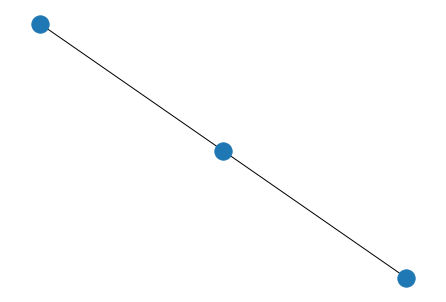

In [80]:
# Creates the graph of interactions for the Heisenberg grid, then draws it

interaction_graph = nx.Graph()
interaction_graph.add_nodes_from(range(0, qubit))
interaction_graph.add_edges_from([(0, 1), (1, 2)])

nx.draw(interaction_graph)

Next, we can implemented a method that actually allows us to calculate the matrix form of our Hamiltonian (in the $Z$-basis). The Ising model Hamiltonian can be written as:

<br>
$$\hat{H} \ = \ \displaystyle\sum_{j} X_{j} X_{j + 1} \ + \ \displaystyle\sum_{i} Z_{i}$$
<br>

We can write this as a function, that returns the $n$-qubit matrix form of the Ising model Hamiltonian:

In [81]:
# Builds the Ising model Hamiltonian, for a given number of qubits and an interaction graph

def create_hamiltonian_matrix(n, graph):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))

    for i in graph.edges:
        m = 1
        for j in range(0, n):
            if (j == i[0] or j == i[1]):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)

    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)


    return matrix

# Constructs the Hamiltonian we will deal with in this simulation

ham_matrix = create_hamiltonian_matrix(qubit, interaction_graph)
print(ham_matrix)

[[ 3.  0.  0.  1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  1.]
 [ 0.  0.  0.  1.  0. -1.  1.  0.]
 [ 1.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  1.  0.  0.  1.  0.  0. -3.]]


With all of this done, all that is left to do is construct the target thermal state. We know that the thermal state is of the form:

<br>
$$\rho_{\text{thermal}} \ = \ \frac{e^{-\beta \hat{H}}}{Z_{\beta}}$$
<br>

Thus, we can calculate it by taking the matrix exponential of the Hamiltonian. The partition function can be found by simply taking the trace of the numerator (as it simply acts as a normalization factor). In addition to finding the thermal state, let's go one step further and also calculate the value of the cost function associated with this target state. Thus, we will have:

In [82]:
# Creates the target density matrix

def create_target(qubit, beta, ham, graph):
    
    # Calculates the matrix form of the density matrix, by taking the exponential of the Hamiltonian
    
    h = ham(qubit, graph)
    y = -1*float(beta)*h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1/norm)*new_matrix

    # Calculates the entropy, the expectation value, and the final cost

    entropy = -1*np.trace(np.matmul(final_target, scipy.linalg.logm(final_target)))
    ev = np.trace(np.matmul(final_target, h))
    real_cost = beta*np.trace(np.matmul(final_target, h)) - entropy

    # Prints the calculated values

    print("Expectation Value: "+str(ev))
    print("Entropy: "+str(entropy))
    print("Final Cost: "+str(real_cost))
    
    return final_target

Finally, we can calculate the thermal state corresponding to our Hamiltonian and inverse temperature, and visualize it using the `seaborn` data visualization library:

Expectation Value: -2.0792714902324483
Entropy: 1.6078317133217728
Final Cost: -2.6474674584379967


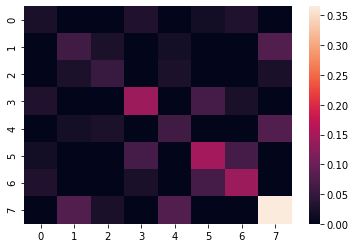

In [83]:
# Plots the final density matrix

final_density_matrix = create_target(qubit, beta, create_hamiltonian_matrix, interaction_graph)
seaborn.heatmap(abs(final_density_matrix))

#### Variational Quantum Thermalization of the Heisenberg Model

Now that we know exactly what our thermal state should look like, let's attempt to construct it with the VQT. Let's begin by constructing the classical probability distribution, which gives us the probabilities corresponding to each basis state in the expansion of our density matrix. As we discussed earlier in this Notebook, we will be using the factorized latent space model. We just have to decide how we will define each probability in the factorized space. We will let the probability associated with the $j$-th one-qubit system be:

<br>
$$p_{j}(\theta_{j}) \ = \ \frac{e^{\theta_j}}{e^{\theta_j} \ + \ 1}$$
<br>

The motivation behind this choice is the fact that this function has a range of $0$ to $1$, which is natural for defining probability without constraining our parameters. In addition, this function is called a sigmoid, and is a common choice as an activation function in machine learning methods. We can implement the sigmoid as:

In [84]:
# Creates the probability distribution according to the theta parameters

def sigmoid(x):

    return (math.exp(x) / (math.exp(x) + 1))

From this, we can construct a function that actually constructs the probability distribution itself, which will be a function that returns a list of pairs of probabilities that correspond to each one-qubit system in the factorized latent space:

In [85]:
# Creates the probability distributions for each of the one-qubit systems

def prob_dist(params):
    
    dist = []
    for i in params:
        dist.append([sigmoid(i), 1-sigmoid(i)])
    
    return dist

Now, with this done, we have to define the quantum parts of our circuit. Befor any qubit register is passed through the variational circuit, we must prepare it in a given basis state. Thus, we can write a function that takes a list of bits, and returns a quantum circuit that prepares the corresponding basis state (in the computational basis): 

In [86]:
#Creates the initialization unitary for each of the computational basis states

def create_v_gate(prep_state):

    for i in range(0, len(prep_state)):
        if (prep_state[i].val == 1):
            qml.PauliX(wires=i)

All that is left to do before we construct the cost function is to construct the parametrized circuit, through which we pass our initial states. We will use a multi-layered ansatz, where each layer is composed of $RX$, $RZ$, and. $RY$ gates on each qubit, followed by exponentiated $CNOT$ gates placed between qubits that share an edge in the interaction graph. Our general single-qubit rotations can be implemented as:

In [87]:
# Creates the single rotational ansatz

def single_rotation(phi_params, q):

    qml.RZ(phi_params[0], wires=q)
    qml.RY(phi_params[1], wires=q)
    qml.RX(phi_params[2], wires=q)

Putting this together with the $CNOT$ gates, we have a general ansatz of the form:

In [88]:
# Creates the ansatz circuit

def ansatz_circuit(params, qubits, layers, graph, param_number):
    
    param_number = int(param_number.val)
    number = param_number*qubit + len(graph.edges)

    # Partitions the parameters into param lists
    partition = []
    for i in range(0, int((len(params)/number))):
        partition.append(params[number*i:number*(i+1)])
    
    qubits = range(qubit)
    
    for j in range(0, depth):
        
        # Implements the single qubit rotations
        sq = partition[j][0:(number-len(graph.edges))]
        for i in qubits:
            single_rotation(sq[i*param_number:(i+1)*param_number], i) 
        
        # Implements the coupling layer of gates
        for count, i in enumerate(graph.edges):
            p = partition[j][(number-len(graph.edges)):number]
            qml.CRX(p[count], wires=[i[0], i[1]])

There are a lot of variables floating around in this function. The `param_number` variable simply tells us how many unique parameters we assign to each application of the single-qubit rotation layer. We multiply this by the number of qubits, to get the total number of single-rotation parameters, and then add the number of edges in the interaction graph, which will also be the number of unique parameters needed for the $CNOT$ gates. With all of these components, we can define a function that acts as our quantum circuit, and pass it into a QNode:

In [89]:
# Defines the depth of the variational circuit

depth = 3

# Creates the quantum circuit

def quantum_circuit(params, qubits, sample, param_number):

    # Prepares the initial basis state corresponding to the sample

    create_v_gate(sample)

    # Prepares the variational ansatz for the circuit

    ansatz_circuit(params, qubits, depth, interaction_graph, param_number)
    
    # Calculates the expectation value of the Hamiltonian, with respect to the preparred states
     
    return qml.expval(qml.Hermitian(ham_matrix, wires=range(qubit)))

qnode = qml.QNode(quantum_circuit, dev)

# Tests and draws the QNode

results = qnode([1 for i in range(0, 12*depth)], qubits, [1, 0, 1, 0], 3)
print(qnode.draw())

 0: ──X──────RZ(1)──RY(1)──RX(1)──╭C───────RZ(1)──RY(1)──RX(1)─────────╭C───────RZ(1)──RY(1)──RX(1)─────────╭C──────────────╭┤ ⟨H0⟩ 
 1: ──RZ(1)──RY(1)──RX(1)─────────╰RX(1)──╭C──────RZ(1)──RY(1)──RX(1)──╰RX(1)──╭C──────RZ(1)──RY(1)──RX(1)──╰RX(1)──╭C──────├┤ ⟨H0⟩ 
 2: ──X──────RZ(1)──RY(1)──RX(1)──────────╰RX(1)──RZ(1)──RY(1)──RX(1)──────────╰RX(1)──RZ(1)──RY(1)──RX(1)──────────╰RX(1)──╰┤ ⟨H0⟩ 
H0 =
[[ 3.  0.  0.  1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  0.  0.]
 [ 1.  0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  1.]
 [ 0.  0.  0.  1.  0. -1.  1.  0.]
 [ 1.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  1.  0.  0.  1.  0.  0. -3.]]



There is one more thing we must do before implementing the cost function: writing a method that allows us to calculate the entropy of a state. Actually implementing a function that calculates the Von Neumann entropy is not too involved. We will take a probability distribution as our argument, each entry of which corresponds to the digonal elements of the $1$-qubit subsystems. The entropy of a collection of subsystems is the same as the sum of the entropies of the indiivdual systems, so we get: 

In [90]:
#Calculate the Von Neumann entropy of the initial density matrices

def calculate_entropy(distribution):

    total_entropy = []
    for i in distribution:
        total_entropy.append(-1*i[0]*np.log(i[0]) + -1*i[1]*np.log(i[1]))
    
    #Returns an array of the entropy values of the different initial density matrices

    return total_entropy

Finally, we define the cost function. More specifically, this is an **exact** version of the VQT cost function. Instead of sampling from our classical probability distribution, we simply calculate the probability corresponding to every basis state, and thus calculate the energy expectation exactly for each iteration. this is not how the VQT would work in the real world, for large systems where the number of basis states (and thus the size of the probability distribution) scales exponentially, but for small toy-models such as this, the exact form runs faster:

In [91]:
def exact_cost(params):
    
    global iterations
    
    # Separates the list of parameters
     
    dist_params = params[0:qubit]
    params = params[qubit:]
    
    # Creates the probability distribution
    
    distribution = prob_dist(dist_params)
    
    # Generates a list of all computational basis states, of our qubit system
    
    s = [[int(i) for i in list(bin(k)[2:].zfill(qubit))] for k in range(0, 2**qubit)]
    
    # Passes each basis state through the variational circuit and multiplis the calculated energy EV with the associated probability from the distribution
    
    final_cost = 0
    for i in s:
        result = qnode(params, qubits, i, 3)
        for j in range(0, len(i)):
            result = result*distribution[j][i[j]]
        final_cost += result
     
    # Calculates the entropy and the final cost function
    
    entropy = calculate_entropy(distribution)
    final_final_cost = beta*final_cost - sum(entropy)
    
    if (iterations%50 == 0):
        print("Cost at Step "+str(iterations)+": "+str(final_final_cost))
    
    iterations += 1
    
    return final_final_cost

Finally, we optimize the cost function:

In [92]:
# Creates the optimizer

iterations = 0
params = [random.randint(-100, 100)/100 for i in range(0, (12*depth)+qubit)]

out = minimize(exact_cost, x0=params, method="COBYLA", options={'maxiter':1000})
params = out['x']
print(out)

Cost at Step 0: -2.1176383145783766
Cost at Step 50: -2.38483180890632
Cost at Step 100: -2.4603699171895306
Cost at Step 150: -2.502590339570166
Cost at Step 200: -2.5328314792536495
Cost at Step 250: -2.5467908341446517
Cost at Step 300: -2.5567138308613586
Cost at Step 350: -2.5673918853462165
Cost at Step 400: -2.5740519878315125
Cost at Step 450: -2.580903647090226
Cost at Step 500: -2.58808340597735
Cost at Step 550: -2.595321266404861
Cost at Step 600: -2.599323571350377
Cost at Step 650: -2.601983618606355
Cost at Step 700: -2.6053946497465073
Cost at Step 750: -2.608323954794461
Cost at Step 800: -2.610838459212761
Cost at Step 850: -2.6144041879825464
Cost at Step 900: -2.6163709721246606
Cost at Step 950: -2.6180279446544454
     fun: -2.619321831658901
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([ 1.40310088, -0.49646623, -1.55976645,  0.55892354,  0.76023784,
       -0.003818

With our optimal parameters, we now wish to prepare the state to which they correspond, to see "how close" our prepared state is to the target state. This can be done by simply taking the optimal parameters, and passing each possible basis state through the variational circuit. Each corresponding probability is multiplied by the outer product of the resulting state with itself. Once we add these all together, we are left with the density matrix corresponding to the optimal parameters.

In [93]:
def prepare_state(params, device):

    # Initializes the density matrix

    final_density_matrix_2 = np.zeros((2**qubit, 2**qubit))

    # Prepares the optimal parameters, creates the distribution and the bitstrings

    dist_params = params[0:qubit]
    unitary_params = params[qubit:]

    distribution = prob_dist(dist_params)

    s = [[int(i) for i in list(bin(k)[2:].zfill(qubit))] for k in range(0, 2**qubit)]

    # Runs the circuit in the case of the optimal parameters, for each bitstring, and adds the result to the final density matrix

    for i in s:
        qnode(unitary_params, qubits, i, 3)
        state = device.state
        for j in range(0, len(i)):
            state = np.sqrt(distribution[j][i[j]])*state
        final_density_matrix_2 = np.add(final_density_matrix_2, np.outer(state, np.conj(state)))
    
    return final_density_matrix_2

final_density_matrix_2 = prepare_state(params, dev)

Now, we need to asess how "close together" the prepared and target state are. The trace distance of two density matrices is a valid metric (a "distance function" with certain properties) on the space on density matrices defined by:

<br>
$$T(\rho, \ \sigma) \ = \ \frac{1}{2} \text{Tr} \sqrt{(\rho \ - \ \sigma)^{\dagger} (\rho \ - \ \sigma)}$$
<br>

We can implement this as a function, and compute the trace distance between the target and prepared states:

In [94]:
# Finds the trace distance between two density matrices

def trace_distance(one, two):
    
    return 0.5*np.trace(np.absolute(np.add(one, -1*two)))

print("Final Trace Distance: "+str(trace_distance(final_density_matrix_2, final_density_matrix)))

Final Trace Distance: 0.056654342507751525


This is pretty good! A trace distance close to $0$ means that the states are "close together", meaning that we prepared a good approximation of the thermal state. If you prefer a vision representation, we can plot the prepared state as a heatmap:

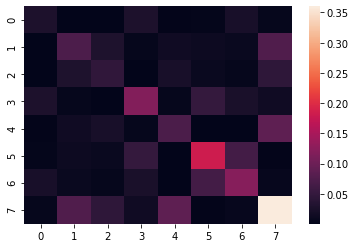

In [95]:
seaborn.heatmap(abs(final_density_matrix_2))

Then, we can compare it to the target:

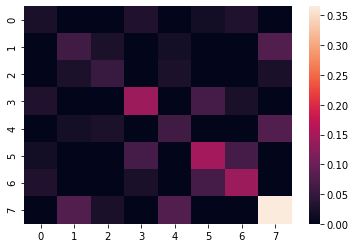

In [96]:
seaborn.heatmap(abs(final_density_matrix))

As you can see, the two images are not completely the same, but there is definitely some resemblance between them!

### The 4-Qubit Heisenberg Model on a Square

Let's look at one more example of the VQT in action, this time, for a slightly more complicated model.

#### Numerical Calculation of Target State

As we did in the above example, we define our fixed values:

In [62]:
# Defines all necessary variables

beta = 1 #Note that B = 1/T
qubit = 4
qubits = range(qubit)
depth = 2

# Defines the device on which the simulation is run

dev2 = qml.device("default.qubit", wires=len(qubits))

This model lives on a square-shaped graph:

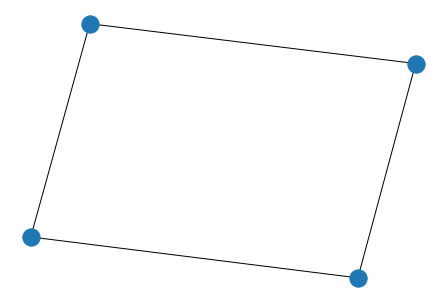

In [63]:
# Creates the graph of interactions for the Heisenberg grid, then draws it

interaction_graph = nx.Graph()
interaction_graph.add_nodes_from(range(0, qubit))
interaction_graph.add_edges_from([(0, 1), (2, 3), (0, 2), (1, 3)])

nx.draw(interaction_graph)

Recall that the two-dimensional Heiseberg model Hamiltonian can be written as:

<br>
$$\hat{H} \ = \ \displaystyle\sum_{(i, j) \in E} X_i X_{j} \ + \ Z_i Z_{j} \ + \ Y_i Y_{j}$$
<br>

With this knowledge, we have:

In [64]:
# Creates the target Hamiltonian matrix

def create_hamiltonian_matrix(n, graph):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])
    
    matrix = np.zeros((2**n, 2**n))
    
    for i in graph.edges:
        m = 1
        for j in range(0, n):
            if (j == i[0] or j == i[1]):
                m = np.kron(pauli_x,  m)
            else:
                m = np.kron(identity, m)
        matrix = np.add(matrix, m)
     
    for i in graph.edges:
        m = 1
        for j in range(0, n):
            if (j == i[0] or j == i[1]):
                m = np.kron(m, pauli_y)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)
    
    for i in graph.edges:
        m = 1
        for j in range(0, n):
            if (j == i[0] or j == i[1]):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, m)
    
    return matrix

ham_matrix = create_hamiltonian_matrix(qubit, interaction_graph)
print(ham_matrix)

[[ 4.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j
   2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j
   2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  2.+0.j -4.+0.j  0.+0.j  0.+0.j
   0.+0.j  2.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.

So this is the $Z$-basis matrix form of the Hamiltonian. We then calculate the thermal state at the inverse temperature defined above:

Expectation Value: (-7.7740126937547025+0j)
Entropy: (0.2817302684780885+9.410928517774377e-17j)
Final Cost: (-8.055742962232792-9.410928517774377e-17j)


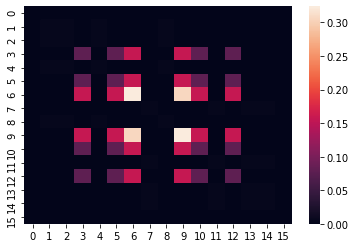

In [65]:
# Plots the final density matrix

final_density_matrix = create_target(qubit, beta, create_hamiltonian_matrix, interaction_graph)
seaborn.heatmap(abs(final_density_matrix))

We will use the same form of the latent space, ansatz, and cost function as above, thus only minor modifications need to be made. We must re-define our qnode, since we are now using a device with $4$ qubits rather than $3$:

In [66]:
# QNode

qnode = qml.QNode(quantum_circuit, dev2)

We then run our optimizer:

In [68]:
# Creates the optimizer

iterations = 0

params = [random.randint(-100, 100)/100 for i in range(0, (16*depth)+qubit)]
out = minimize(exact_cost, x0=params, method="COBYLA", options={'maxiter':1000})
params = out['x']
print(out)

Cost at Step 0: -2.463309686334111
Cost at Step 50: -3.575598119327056
Cost at Step 100: -4.2764465592481855
Cost at Step 150: -4.897385818202105
Cost at Step 200: -5.697996684999241
Cost at Step 250: -6.056739517351948
Cost at Step 300: -6.192468440564735
Cost at Step 350: -6.614680190085132
Cost at Step 400: -6.864884977228145
Cost at Step 450: -6.893200509986737
Cost at Step 500: -6.984379931895425
Cost at Step 550: -7.129821923572679
Cost at Step 600: -7.21980046742897
Cost at Step 650: -7.265795873808539
Cost at Step 700: -7.326021050662185
Cost at Step 750: -7.361579645110834
Cost at Step 800: -7.385540542539021
Cost at Step 850: -7.413757395341174
Cost at Step 900: -7.450772472320012
Cost at Step 950: -7.472225423815771
     fun: -7.491177408045373
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([-3.42920882e+00,  3.65497026e+00,  4.21382890e+00, -4.04237746e+00,
       -6.71724205e-01

With our optimal parameters, we can post-process our data. We start by calculating the matrix form of the density matrix we prepared:

In [69]:
# Prepares the density matrix

final_density_matrix_2 = prepare_state(params, dev2)

We then calculate the trace distance:

In [72]:
# Calculates the trace distance

print("Final Trace Distance: "+str(trace_distance(final_density_matrix_2, final_density_matrix)))

Final Trace Distance: 0.07022044241758019


This is pretty good, but it could be better (most likely with a deeper ansatz and a more sophisticated optimizer, but to keep execution time relatively sohrt, we will not go down those avenues in this Notebook). To end off, let's visualize our two density matrices:

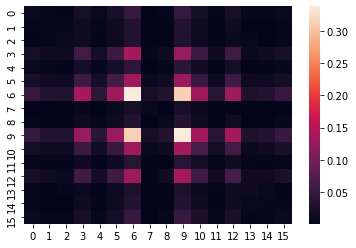

In [71]:
seaborn.heatmap(abs(final_density_matrix_2))

And we print the target:

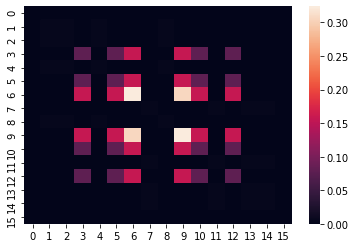

In [241]:
seaborn.heatmap(abs(final_density_matrix))

### References

1. Verdon, G., Marks, J., Nanda, S., Leichenauer, S., & Hidary, J. (2019). Quantum Hamiltonian-Based Models and the Variational Quantum Thermalizer Algorithm. arXiv preprint [arXiv:1910.02071](https://arxiv.org/abs/1910.02071).